In [19]:
#Data Loading and Initial Exploration
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, f_oneway, wilcoxon, chi2_contingency, linregress
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import dash
from dash import dcc, html
import plotly.express as px

In [2]:
df=pd.read_csv("fuel consumption.csv")

In [3]:
df.head()

,STATISTIC,Statistic Label,C02405V02899,Sector,TLIST(A1),Year,C02404V02898,Fuel Type,UNIT,VALUE
0,SEI06,Fuel Consumption (ktoe),14,Final energy consumption,1990,1990,01,Sum of all coal products,ktoe,843
1,SEI06,Fuel Consumption (ktoe),14,Final energy consumption,1990,1990,0101,Bituminous coal,ktoe,825
2,SEI06,Fuel Consumption (ktoe),14,Final energy consumption,1990,1990,0102,Anthracite and manufactured ovoids,ktoe,0
3,SEI06,Fuel Consumption (ktoe),14,Final energy consumption,1990,1990,0103,Coke,ktoe,0
4,SEI06,Fuel Consumption (ktoe),14,Final energy consumption,1990,1990,0104,Lignite,ktoe,18


In [4]:
df.tail()

,STATISTIC,Statistic Label,C02405V02899,Sector,TLIST(A1),Year,C02404V02898,Fuel Type,UNIT,VALUE
65335,SEI06,Fuel Consumption (ktoe),2001,Fisheries,2022,2022,10,Non renewable waste,ktoe,0
65336,SEI06,Fuel Consumption (ktoe),2001,Fisheries,2022,2022,06,Electricity,ktoe,0
65337,SEI06,Fuel Consumption (ktoe),2001,Fisheries,2022,2022,07,Heat,ktoe,0
65338,SEI06,Fuel Consumption (ktoe),2001,Fisheries,2022,2022,-,Sum of all fuel products,ktoe,28
65339,SEI06,Fuel Consumption (ktoe),2001,Fisheries,2022,2022,0509,Geothermal,ktoe,0


In [5]:
df.shape

(65340, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65340 entries, 0 to 65339
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        65340 non-null  object
 1   Statistic Label  65340 non-null  object
 2   C02405V02899     65340 non-null  int64 
 3   Sector           65340 non-null  object
 4   TLIST(A1)        65340 non-null  int64 
 5   Year             65340 non-null  int64 
 6   C02404V02898     65340 non-null  object
 7   Fuel Type        65340 non-null  object
 8   UNIT             65340 non-null  object
 9   VALUE            65340 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 5.0+ MB


In [7]:
df.describe()

,C02405V02899,TLIST(A1),Year,VALUE
count,65340.000000,65340.000000,65340.000000,65340.000000
mean,45580.533333,2006.000000,2006.000000,45.377242
std,77484.891249,9.521977,9.521977,372.367829
min,14.000000,1990.000000,1990.000000,0.000000
25%,1601.000000,1998.000000,1998.000000,0.000000
50%,1612.000000,2006.000000,2006.000000,0.000000
75%,17302.000000,2014.000000,2014.000000,0.000000
max,190204.000000,2022.000000,2022.000000,13189.000000


In [20]:
df.isnull().sum()
# Check for missing values

Statistic Label    0
Code of Sector     0
Sector             0
Year               0
Code of Fuel       0
Fuel Type          0
VALUE              0
dtype: int64

In [21]:
# Check for negative values (invalid for consumption)
print("Number of negative VALUE entries:", (df['VALUE'] < 0).sum())

Number of negative VALUE entries: 0


In [9]:
duplicate_rows_df=df[df.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)
#checking the duplicated rows

number of duplicate rows: (0, 10)


In [22]:
# Verify all years from 1990 to 2022 are present
all_years = set(range(1990, 2023))
present_years = set(df['Year'].unique())
print("Missing years:", all_years - present_years)

Missing years: set()


In [10]:
df=df.drop(["STATISTIC","TLIST(A1)", "UNIT"], axis=1)
df=df.rename(columns={"C02405V02899":"Code of Sector","C02404V02898":"Code of Fuel"})
df.head()
#dropping irrelevant(duplicated meaning) columns
#renaming the column

,Statistic Label,Code of Sector,Sector,Year,Code of Fuel,Fuel Type,VALUE
0,Fuel Consumption (ktoe),14,Final energy consumption,1990,01,Sum of all coal products,843
1,Fuel Consumption (ktoe),14,Final energy consumption,1990,0101,Bituminous coal,825
2,Fuel Consumption (ktoe),14,Final energy consumption,1990,0102,Anthracite and manufactured ovoids,0
3,Fuel Consumption (ktoe),14,Final energy consumption,1990,0103,Coke,0
4,Fuel Consumption (ktoe),14,Final energy consumption,1990,0104,Lignite,18


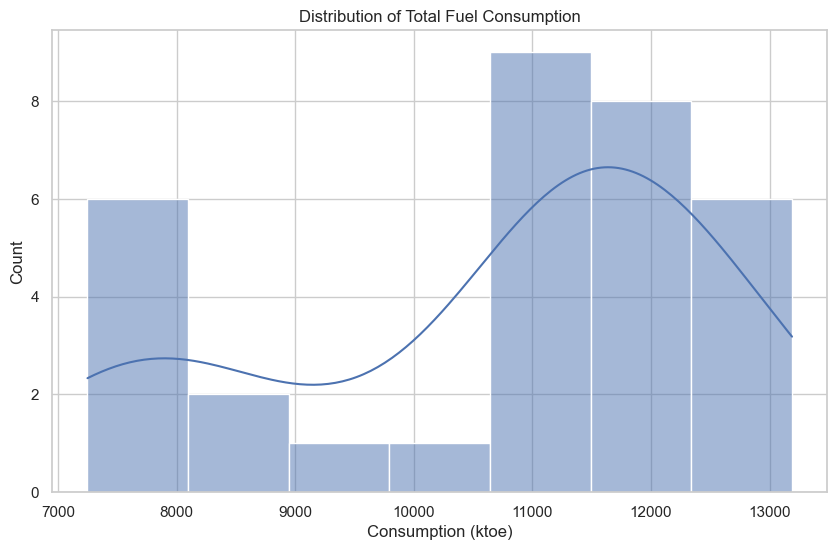

In [25]:
# Distribution of total consumption
total_consumption = df[(df['Sector'] == 'Final energy consumption') & (df['Fuel Type'] == 'Sum of all fuel products')][['Year', 'VALUE']]
plt.figure(figsize=(10, 6))
sns.histplot(total_consumption['VALUE'], kde=True)
plt.title('Distribution of Total Fuel Consumption')
plt.xlabel('Consumption (ktoe)')
plt.show()

<Axes: xlabel='VALUE'>

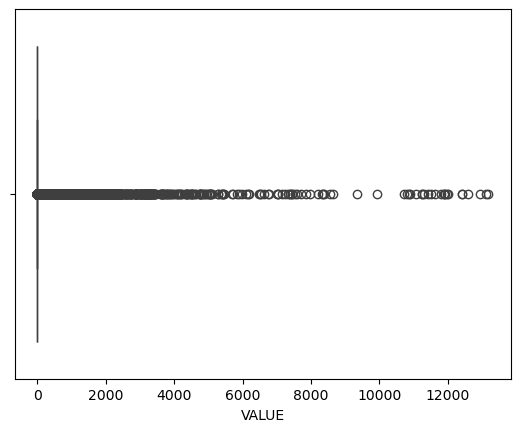

In [11]:
import matplotlib.pyplot as plt
sns.boxplot(x=df["VALUE"])
#detecting outliers

## Histogram

<Figure size 1400x600 with 0 Axes>

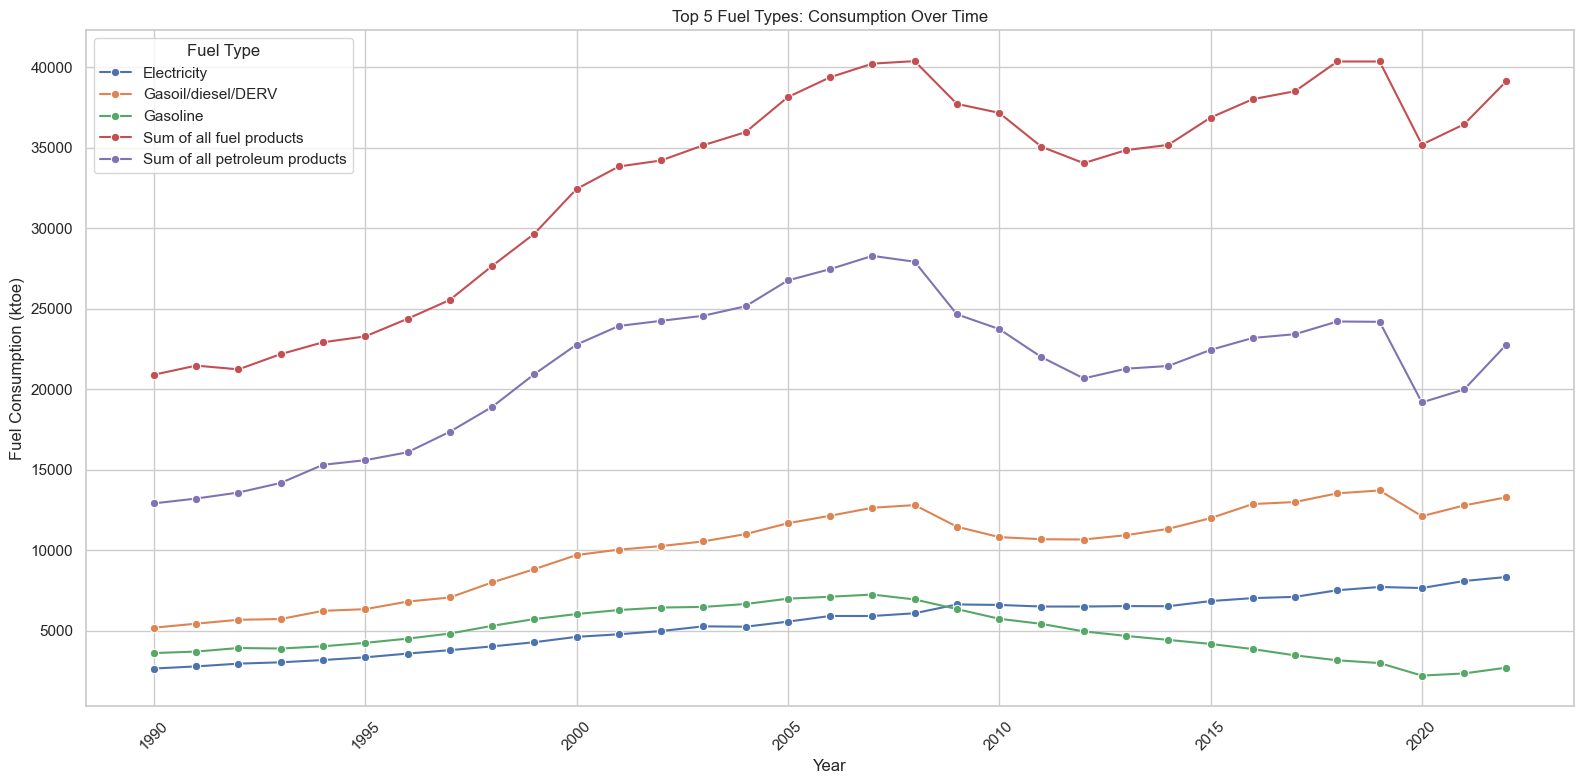

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Aggregate data by Year and Fuel Type
fuel_yearly = df.groupby(['Year', 'Fuel Type'])['VALUE'].sum().reset_index()

# Plot fuel consumption over time for top 5 fuel types by total consumption
top_fuels = fuel_yearly.groupby('Fuel Type')['VALUE'].sum().nlargest(5).index
fuel_top = fuel_yearly[fuel_yearly['Fuel Type'].isin(top_fuels)]

# Lineplot
plt.figure(figsize=(16, 8))
sns.lineplot(data=fuel_top, x='Year', y='VALUE', hue='Fuel Type', marker="o")
plt.title('Top 5 Fuel Types: Consumption Over Time')
plt.xlabel('Year')
plt.ylabel('Fuel Consumption (ktoe)')
plt.legend(title='Fuel Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\nzaya\AppData\Local\Temp\ipykernel_17140\888926242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_total, x='Year', y='VALUE', palette='Blues_d')


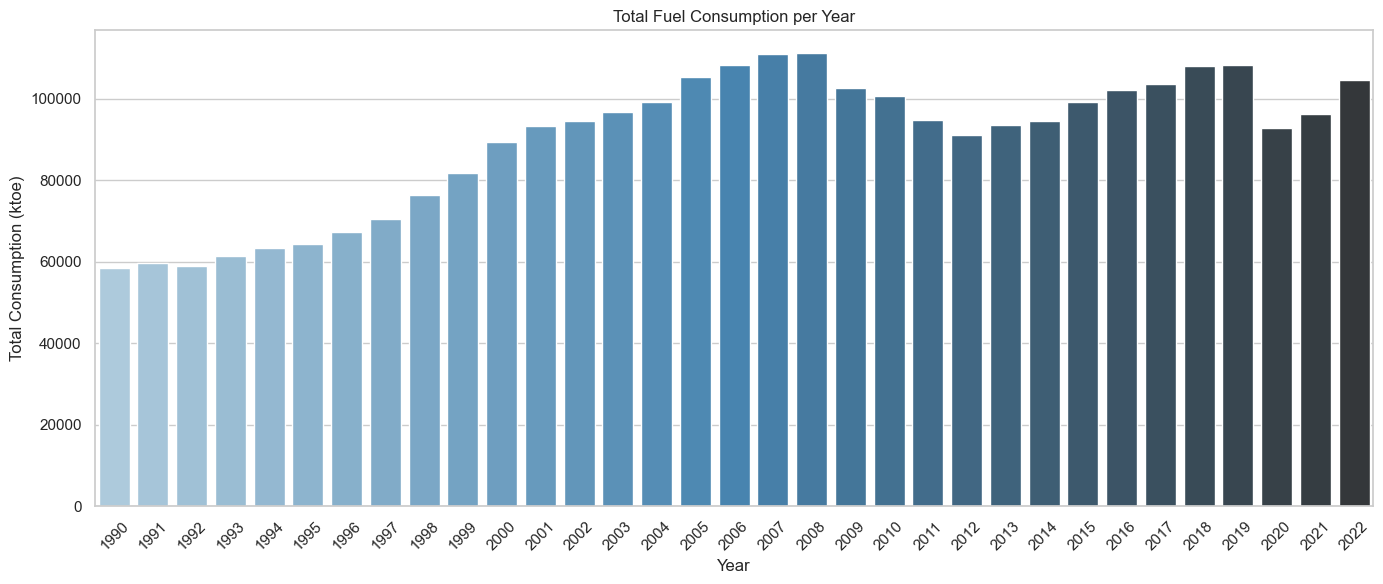

In [13]:
plt.figure(figsize=(14, 6))
yearly_total = df.groupby('Year')['VALUE'].sum().reset_index()
sns.barplot(data=yearly_total, x='Year', y='VALUE', palette='Blues_d')
plt.title('Total Fuel Consumption per Year')
plt.xlabel('Year')
plt.ylabel('Total Consumption (ktoe)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

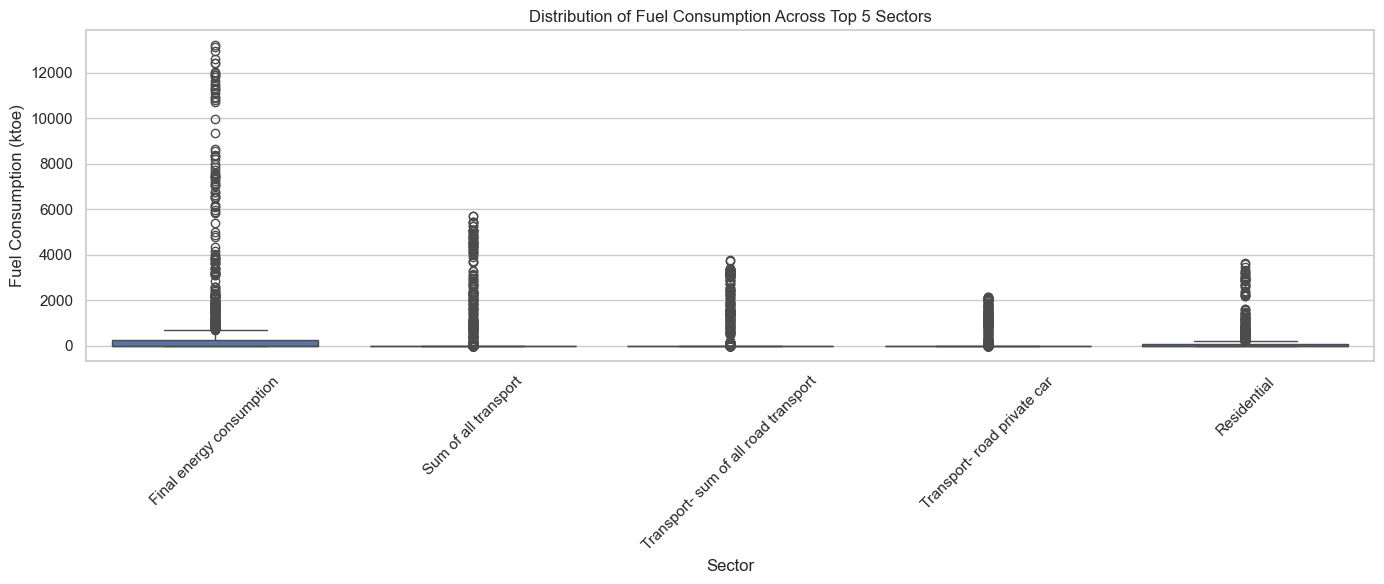

In [14]:
top_sectors = df.groupby('Sector')['VALUE'].sum().nlargest(5).index
sector_data = df[df['Sector'].isin(top_sectors)]
plt.figure(figsize=(14, 6))
sns.boxplot(data=sector_data, x='Sector', y='VALUE')
plt.title('Distribution of Fuel Consumption Across Top 5 Sectors')
plt.ylabel('Fuel Consumption (ktoe)')
plt.xlabel('Sector')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

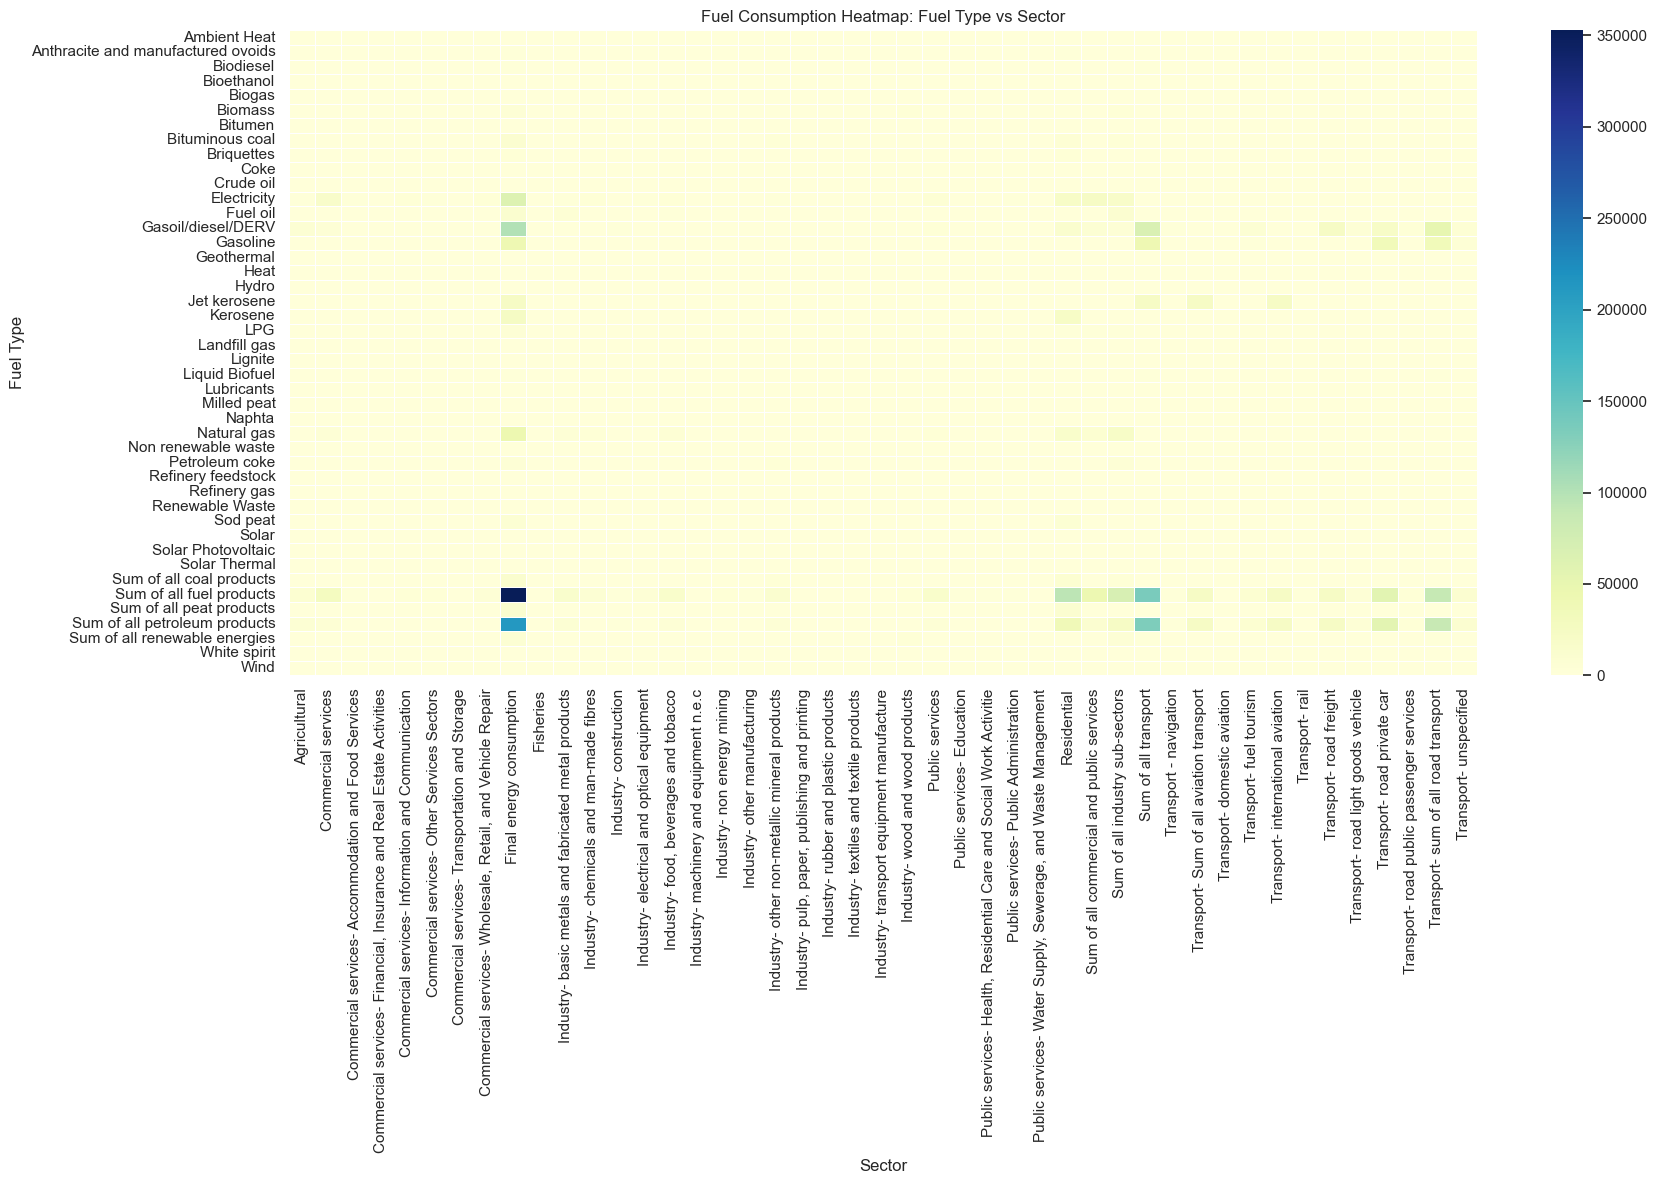

In [15]:
pivot_table = df.pivot_table(values='VALUE', index='Fuel Type', columns='Sector', aggfunc='sum', fill_value=0)
plt.figure(figsize=(18, 12))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.5)
plt.title('Fuel Consumption Heatmap: Fuel Type vs Sector')
plt.xlabel('Sector')
plt.ylabel('Fuel Type')
plt.tight_layout()
plt.show()

## Statistic

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df=pd.read_csv("fuel consumption.csv")
df=df.drop(["STATISTIC","TLIST(A1)", "UNIT"], axis=1)
df=df.rename(columns={"C02405V02899":"Code of Sector","C02404V02898":"Code of Fuel"})
print("Dataset Summary:")
print(df.describe())
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')

Dataset Summary:
       Code of Sector          Year         VALUE
count    65340.000000  65340.000000  65340.000000
mean     45580.533333   2006.000000     45.377242
std      77484.891249      9.521977    372.367829
min         14.000000   1990.000000      0.000000
25%       1601.000000   1998.000000      0.000000
50%       1612.000000   2006.000000      0.000000
75%      17302.000000   2014.000000      0.000000
max     190204.000000   2022.000000  13189.000000


In [26]:
# Total consumption stats
print("Descriptive statistics for total consumption:")
print(total_consumption['VALUE'].describe())

Descriptive statistics for total consumption:
count       33.000000
mean     10687.575758
std       1854.085843
min       7249.000000
25%       9356.000000
50%      11262.000000
75%      11910.000000
max      13189.000000
Name: VALUE, dtype: float64


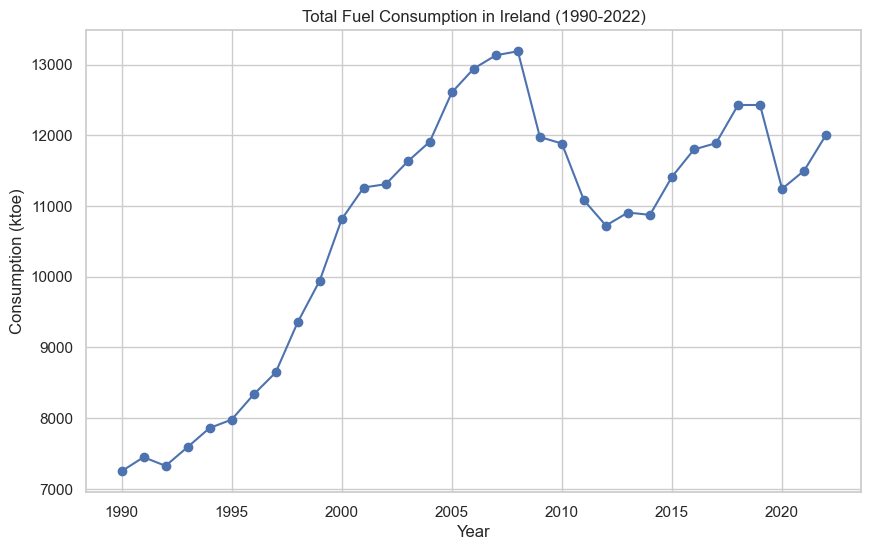

In [27]:
# Yearly trend
plt.figure(figsize=(10, 6))
plt.plot(total_consumption['Year'], total_consumption['VALUE'], marker='o')
plt.title('Total Fuel Consumption in Ireland (1990-2022)')
plt.xlabel('Year')
plt.ylabel('Consumption (ktoe)')
plt.grid(True)
plt.show()

In [30]:
#Inferential Statistics
# Filter main fuel types for "Final energy consumption"
main_consumption = df[(df['Sector'] == 'Final energy consumption') & (df['Code of Fuel'].str.len() == 2)]

# Test 1: Paired t-test (Petroleum vs. Natural Gas)
petroleum = main_consumption[main_consumption['Fuel Type'] == 'Sum of all petroleum products']['VALUE']
natural_gas = main_consumption[main_consumption['Fuel Type'] == 'Natural gas']['VALUE']
t_stat, p_val = ttest_rel(petroleum.values[:len(natural_gas)], natural_gas.values)
print(f"T-test (Petroleum vs. Natural Gas): t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")

T-test (Petroleum vs. Natural Gas): t-stat = 26.67, p-value = 0.0000


In [31]:
# Test 2: ANOVA (Across main fuel types)
fuel_groups = [group['VALUE'].values for name, group in main_consumption.groupby('Fuel Type')]
f_stat, p_val = f_oneway(*fuel_groups)
print(f"ANOVA (Across Fuel Types): F-stat = {f_stat:.2f}, p-value = {p_val:.4f}")

ANOVA (Across Fuel Types): F-stat = 573.25, p-value = 0.0000


In [32]:
# Test 3: Wilcoxon (Coal vs. Peat, non-parametric)
coal = main_consumption[main_consumption['Fuel Type'] == 'Sum of all coal products']['VALUE']
peat = main_consumption[main_consumption['Fuel Type'] == 'Sum of all peat products']['VALUE']
w_stat, p_val = wilcoxon(coal.values[:len(peat)], peat.values)
print(f"Wilcoxon (Coal vs. Peat): stat = {w_stat:.2f}, p-value = {p_val:.4f}")

Wilcoxon (Coal vs. Peat): stat = 96.00, p-value = 0.0006


In [33]:
# Test 4: Chi-squared (Proportion of Renewables vs. Total)
renewables = main_consumption[main_consumption['Fuel Type'] == 'Sum of all renewable energies']['VALUE']
contingency = pd.crosstab(total_consumption['VALUE'] > total_consumption['VALUE'].median(), 
                          renewables > renewables.median())
chi2, p_val, _, _ = chi2_contingency(contingency)
print(f"Chi-squared (Renewables vs. Total): chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

ValueError: No data; `observed` has size 0.

In [34]:
# Test 5: Linear Regression (Trend in Renewable Proportion)
proportion_renewable = renewables.values / total_consumption['VALUE'].values[:len(renewables)]
slope, intercept, r_value, p_val, _ = linregress(total_consumption['Year'].values[:len(renewables)], proportion_renewable)
print(f"Regression (Renewable Trend): slope = {slope:.4f}, p-value = {p_val:.4f}")

Regression (Renewable Trend): slope = 0.0011, p-value = 0.0000


## Machine Learning

In [35]:
train = total_consumption[total_consumption['Year'] <= 2015]
test = total_consumption[total_consumption['Year'] > 2015]

In [36]:
# Model 1: ARIMA
adf_result = adfuller(train['VALUE'])
print(f"ADF Test: p-value = {adf_result[1]:.4f}")  # Check stationarity
model = ARIMA(train['VALUE'], order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
arima_mae = mean_absolute_error(test['VALUE'], forecast)
print(f"ARIMA MAE: {arima_mae:.2f}")

ADF Test: p-value = 0.0148
ARIMA MAE: 393.47


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

In [37]:
# Model 2: Random Forest with GridSearchCV
total_consumption['Lag1'] = total_consumption['VALUE'].shift(1)
total_consumption.dropna(inplace=True)
train = total_consumption[total_consumption['Year'] <= 2015]
test = total_consumption[total_consumption['Year'] > 2015]
X_train, y_train = train[['Lag1']], train['VALUE']
X_test, y_test = test[['Lag1']], test['VALUE']
param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
rf_forecast = grid_search.best_estimator_.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_forecast)
print(f"Random Forest MAE: {rf_mae:.2f}")

Random Forest MAE: 568.56


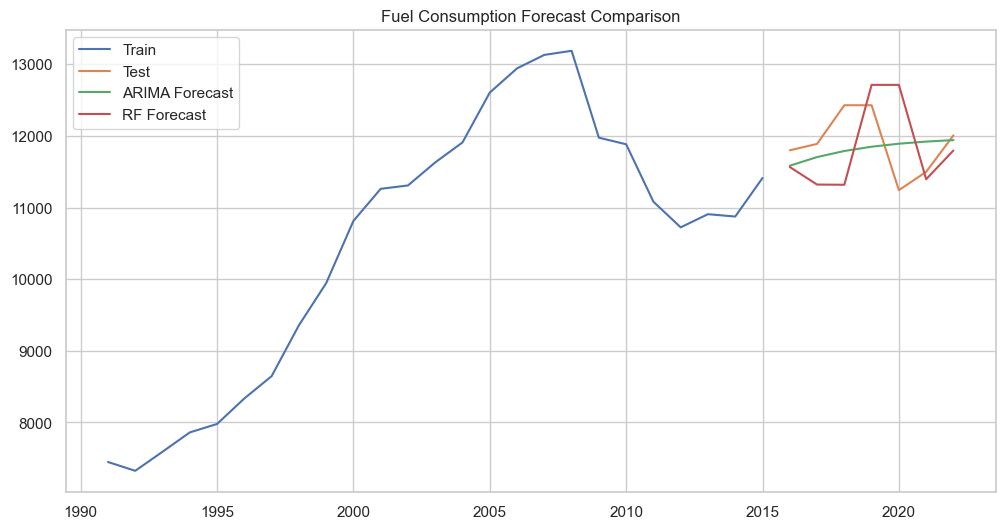

In [38]:
# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(train['Year'], train['VALUE'], label='Train')
plt.plot(test['Year'], test['VALUE'], label='Test')
plt.plot(test['Year'], forecast, label='ARIMA Forecast')
plt.plot(test['Year'], rf_forecast, label='RF Forecast')
plt.legend()
plt.title('Fuel Consumption Forecast Comparison')
plt.show()

In [41]:
#pip install dash

In [42]:
#Interactive Dashboard
app = dash.Dash(__name__)
fuel_options = [{'label': fuel, 'value': fuel} for fuel in main_consumption['Fuel Type'].unique()]
app.layout = html.Div([
    dcc.Dropdown(id='fuel-dropdown', options=fuel_options, value='Sum of all fuel products'),
    dcc.Graph(id='fuel-graph')
])

@app.callback(
    dash.Output('fuel-graph', 'figure'),
    [dash.Input('fuel-dropdown', 'value')]
)
def update_graph(selected_fuel):
    fuel_data = main_consumption[main_consumption['Fuel Type'] == selected_fuel]
    fig = px.line(fuel_data, x='Year', y='VALUE', title=f'Consumption of {selected_fuel}')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

ObsoleteAttributeException: app.run_server has been replaced by app.run